ANÁLISIS SUPERVISADO - REGRESIÓN
Dataset: articulos_ml.csv
Dimensiones originales: (161, 8)
Columnas: ['Title', 'url', 'Word count', '# of Links', '# of comments', '# Images video', 'Elapsed days', '# Shares']
                                               Title  \
0  What is Machine Learning and how do we use it ...   
1   10 Companies Using Machine Learning in Cool Ways   
2  How Artificial Intelligence Is Revolutionizing...   
3  Dbrain and the Blockchain of Artificial Intell...   
4  Nasa finds entire solar system filled with eig...   

                                                 url  Word count  # of Links  \
0  https://blog.signals.network/what-is-machine-l...        1888           1   
1                                                NaN        1742           9   
2                                                NaN         962           6   
3                                                NaN        1221           3   
4                                                NaN 

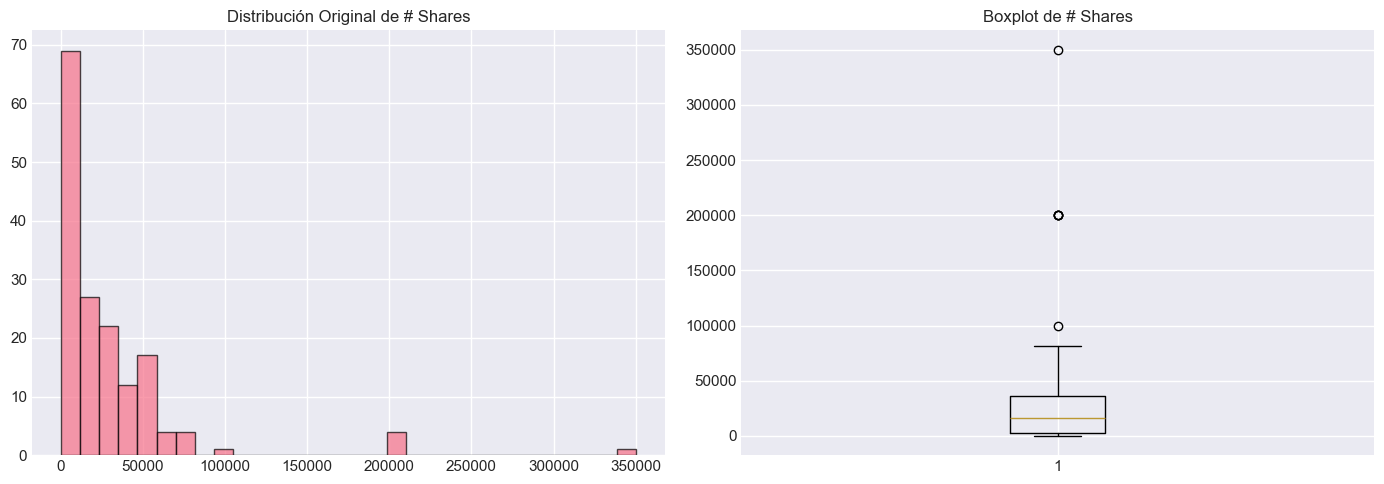

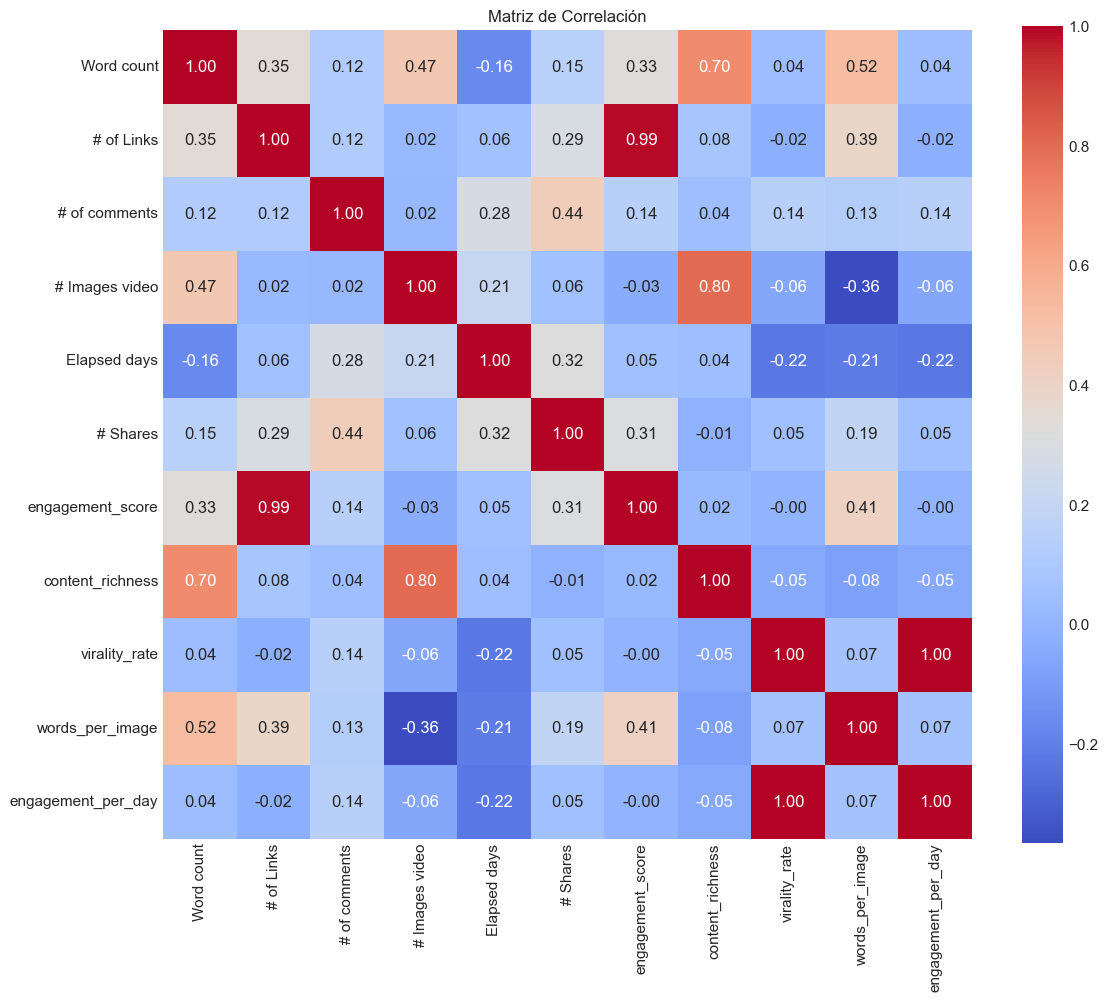

              Feature  Importance
6    content_richness    0.148760
0          Word count    0.138642
1          # of Links    0.134790
4        Elapsed days    0.113561
2       # of comments    0.100383
8     words_per_image    0.100349
7       virality_rate    0.081174
5    engagement_score    0.069684
9  engagement_per_day    0.057864
3      # Images video    0.054793


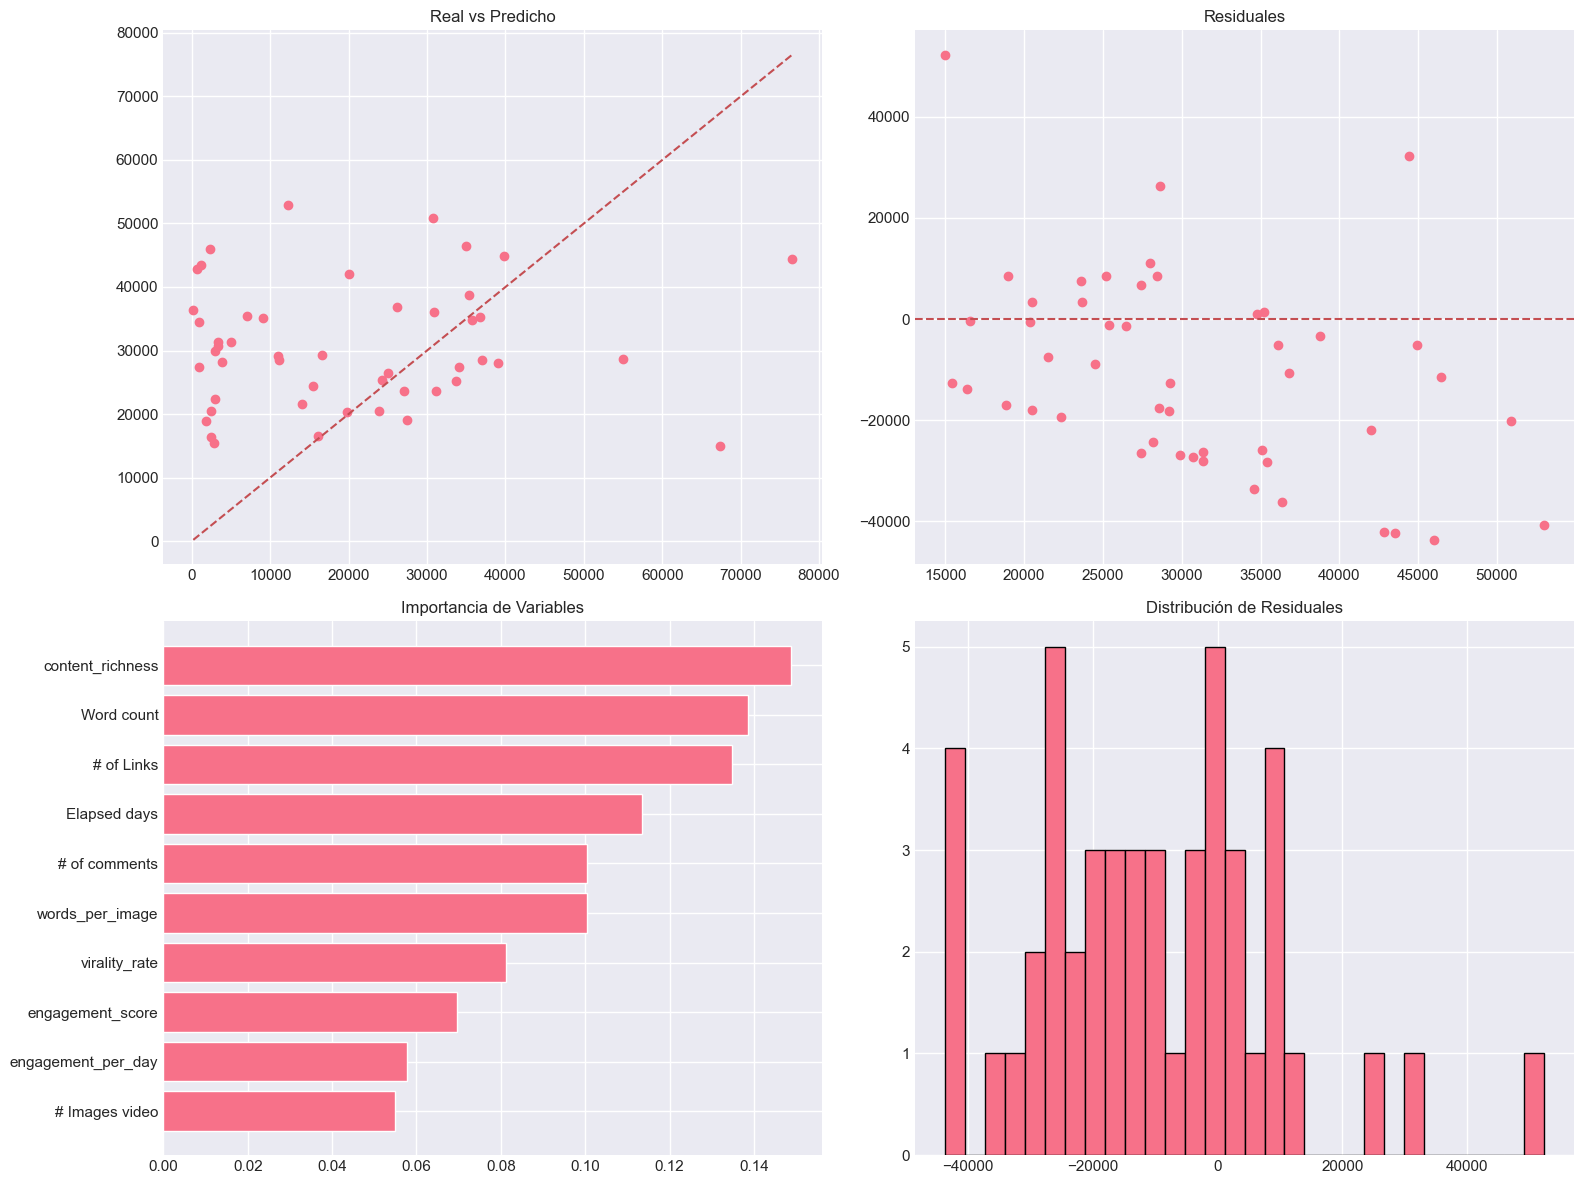

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("ANÁLISIS SUPERVISADO - REGRESIÓN")
print("Dataset: articulos_ml.csv")
print("="*80)

# 1. CARGA Y EXPLORACIÓN DE DATOS
ruta = r"C:\Users\Margoth Rodríguez\Downloads\articulos_ml.csv"
df = pd.read_csv(ruta)

print("Dimensiones originales:", df.shape)
print("Columnas:", list(df.columns))
print(df.head())
print(df.describe())
print("Valores nulos por columna:")
print(df.isnull().sum())

# Visualización de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['# Shares'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución Original de # Shares')
axes[1].boxplot(df['# Shares'])
axes[1].set_title('Boxplot de # Shares')
plt.tight_layout()
plt.savefig('01_exploracion_inicial.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. PREPROCESAMIENTO DE DATOS
df_clean = df.drop(['Title', 'url'], axis=1)
df_clean = df_clean[df_clean['# Shares'] > 0]

df_clean['engagement_score'] = df_clean['# of comments'].fillna(0) * df_clean['# of Links']
df_clean['content_richness'] = df_clean['Word count'] * df_clean['# Images video']
df_clean['virality_rate'] = df_clean['# of comments'].fillna(0) / (df_clean['Elapsed days'] + 1)
df_clean['words_per_image'] = df_clean['Word count'] / (df_clean['# Images video'] + 1)
df_clean['engagement_per_day'] = df_clean['# of comments'].fillna(0) / (df_clean['Elapsed days'] + 1)

X = df_clean.drop('# Shares', axis=1)
y = df_clean['# Shares']

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.savefig('02_correlacion.png', dpi=300)
plt.show()

# 3. JUSTIFICACIÓN DEL ALGORITMO (texto para reporte, no en consola)
"""
Se seleccionó Random Forest porque maneja relaciones no lineales, es robusto a outliers,
proporciona importancia de variables y reduce la varianza gracias al ensamble de árboles.
"""

# 4. ENTRENAMIENTO Y OPTIMIZACIÓN DEL MODELO
rf_baseline = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_scaled, y_train)

y_test_pred_baseline = rf_baseline.predict(X_test_scaled)

r2_baseline = r2_score(y_test, y_test_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 8, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_

y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='r2')

# 5. EVALUACIÓN DEL MODELO
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# 6. FEATURE IMPORTANCE
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

# 7. VISUALIZACIONES FINALES
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(y_test, y_test_pred)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_title('Real vs Predicho')

residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals)
axes[0, 1].axhline(0, color='r', linestyle='--')
axes[0, 1].set_title('Residuales')

top_features = importance_df.head(10)
axes[1, 0].barh(top_features['Feature'], top_features['Importance'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_title('Importancia de Variables')

axes[1, 1].hist(residuals, bins=30, edgecolor='black')
axes[1, 1].set_title('Distribución de Residuales')

plt.tight_layout()
plt.savefig('04_evaluacion_modelo.png', dpi=300)
plt.show()

# 9. GUARDAR MODELO
import joblib
joblib.dump(best_rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')

# 10. RESUMEN EJECUTIVO (sin emojis ni recuadros)
with open('resumen_modelo.txt', 'w', encoding='utf-8') as f:
    f.write(
        f"RESUMEN EJECUTIVO\n"
        f"Modelo: Random Forest Regressor\n"
        f"R2 Train: {r2_train:.4f}\n"
        f"R2 Test: {r2_test:.4f}\n"
        f"RMSE Test: {rmse_test:.0f}\n"
        f"MAE Test: {mae_test:.0f}\n"
        f"MAPE: {mape_test:.1f}%\n"
        f"Mejoras futuras: incluir más datos, ingeniería de características avanzadas.\n"
    )
